### how to utilize this model

## Download data

[wikiart](https://huggingface.co/datasets/huggan/wikiart)

In [1]:
# get images

import os
from PIL import Image
from datasets import Dataset

# Define the root directory
# root_directory = 'wikiart'
root_directory = 'wikiart_subset'
collected_images = []
count = 0
image_list = []
style_list = []

# Iterate through the subdirectories
for subdir in os.listdir(root_directory):
    subdirectory_path = os.path.join(root_directory, subdir)

    # Check if the subdirectory is actually a directory
    if os.path.isdir(subdirectory_path):

        # Iterate through the files in the subdirectory
        for filename in os.listdir(subdirectory_path):
            file_path = os.path.join(subdirectory_path, filename)

            # Print the file path and name
            style = file_path.replace(root_directory+"\\", "").replace("\\"+filename, "")
            # print("File path:", file_path)
            # print("File name:", filename)
            # print("style: ",style)
            
            # Open the image file
            image_path = "path_to_your_image.jpg"  # Replace with the actual path to your image
            image = Image.open(file_path)
            image = image.convert("RGB")
            image_list.append(image)
            style_list.append(style)

            # Verify the image type
            if not isinstance(image, Image.Image):
                print("Failed to load the image.")
                print(type(image))
                print("")

            # record the index into list
            collected_images.append(count)
            count = count + 1
            if count%100==0:
                print(count)
            if count%1000 == 0:
                break
print("turn data to dict")
data = {"image": image_list, "style": style_list}
print("turn data to dataset")
train_ds = Dataset.from_dict(data)
train_ds[0]["style"]

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
turn data to dict
turn data to dataset


'Art_Nouveau_Modern'

#### hide

In [2]:
len(train_ds)

3000

## Label preprocessing

1. one hot encoding
2. split data
3. turn to tensor

In [3]:
style_data = []
unique_style = set()
# numbers that represent styles to corresponding string
for index in range(len(train_ds)):
  current_style_name = train_ds[index]["style"]
  unique_style.add(current_style_name)
  style_data.append(current_style_name)
style_amount = len(unique_style)
style_amount

3

In [4]:
# one hot encoding
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# fake data: style_data = ["Realism", "Baroque", "Post_Impressionism", "Impressionism", "Romanticism"]
style_dataframe = pd.DataFrame(style_data, columns=['Style'])
style_dataframe_with_one_hot_encoding = pd.get_dummies(style_dataframe)

# split data
random_seed = 42
train_labels, val_labels = train_test_split(style_dataframe_with_one_hot_encoding, test_size=0.2, random_state=random_seed)

# convert to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
style_dataframe_with_one_hot_encoding

,Style_Art_Nouveau_Modern,Style_Baroque,Style_Expressionism
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
2995,0,0,1
2996,0,0,1
2997,0,0,1
2998,0,0,1


## Image preprocessing

1. split data
2. convert to tensor + resize image

In [5]:
# resize image
from PIL import Image

# Specify the desired width and height for resizing
desired_width = 256
desired_height = 256

def resize_image(image):
  return image.resize((desired_width, desired_height))

In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# split into training and testing
# train_data, test_data = train_test_split(resized_train_ds, test_size=0.2, random_state=42)

# split training into training and validation
train_data, val_data = train_test_split(collected_images, test_size=0.2, random_state=random_seed)

# Convert train_data and val_data to TensorFlow tensors
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

# Convert train_data and val_data to TensorFlow tensors
train_images = []
for index in train_data:
  image_resized = resize_image(train_ds[index]['image'])
  image_array = img_to_array(image_resized)
  train_images.append(image_array)
train_images = tf.convert_to_tensor(train_images)

val_images = []
for index in val_data:
  image_resized = resize_image(train_ds[index]['image'])
  image_array = img_to_array(image_resized)
  val_images.append(image_array)
val_images = tf.convert_to_tensor(val_images)

# Normalize and resize the images
train_images = train_images / 255.0  # Normalize pixel values to the range [0, 1]
val_images = val_images / 255.0

# Verify the shape of the tensors
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Train images shape: (2400, 256, 256, 3)
Train labels shape: (2400, 3)
Validation images shape: (600, 256, 256, 3)
Validation labels shape: (600, 3)


## Transfer Learning

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, models, applications
layer_model = applications.VGG16(
    include_top = False, # We do not include VGG classification layers
    weights = 'imagenet', # We import VGG pre-trained on ImageNet
    input_shape = (desired_height, desired_width, 3),
    classes = style_amount)

layer_model.trainable = False

layer_model.layers[-2:] # Set the two last layers as trainable (including the last Conv2D)

for layer in layer_model.layers[-2:]:
    layer.trainable = True

trainable_layer_count = 0

for i in range(len(layer_model.layers)):
    if layer_model.layers[i].trainable:
        trainable_layer_count += 1

trainable_layer_count

2

In [8]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
data_augmentation_layers = models.Sequential([
    RandomFlip("horizontal", input_shape=(desired_height, desired_width, 3)),
    RandomRotation(0.3),
    RandomZoom(0.3)])

In [9]:
import tensorflow as tf
from tensorflow.keras import Input, Model

tf.keras.backend.clear_session() # Clear the layers name (in case you run multiple time the cell)

inputs = Input(shape=(desired_height, desired_width, 3))

x = data_augmentation_layers(inputs) # Are not applied to validation and test dataset (made inactive, tensorflow handle it)
x = applications.vgg16.preprocess_input(x) # Does the rescaling
x = layer_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x) # Dropout to prevent overfitting

outputs = layers.Dense(style_amount, activation='softmax', name='classification_layer')(x)

model = Model(inputs, outputs)

### training

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adamax

es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
tsboard = TensorBoard(log_dir='logs')

# origin learning rate = 0.001
model.compile(optimizer=Adamax(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history = model.fit(
    train_images,
    train_labels,
    epochs=40,
    validation_data=(val_images, val_labels),
    callbacks=[tsboard],
    use_multiprocessing=True)

# save your model

model.save(f"./model")

Epoch 1/40
75/75 [==============================] - 311s 4s/step - loss: 1.5007 - accuracy: 0.3237 - val_loss: 1.1035 - val_accuracy: 0.3350
Epoch 2/40
75/75 [==============================] - 309s 4s/step - loss: 1.2900 - accuracy: 0.3283 - val_loss: 1.0953 - val_accuracy: 0.3517
Epoch 3/40
75/75 [==============================] - 316s 4s/step - loss: 1.1863 - accuracy: 0.3308 - val_loss: 1.0953 - val_accuracy: 0.3133
Epoch 4/40
75/75 [==============================] - 312s 4s/step - loss: 1.1308 - accuracy: 0.3450 - val_loss: 1.0894 - val_accuracy: 0.4383
Epoch 5/40
75/75 [==============================] - 310s 4s/step - loss: 1.1134 - accuracy: 0.3383 - val_loss: 1.0888 - val_accuracy: 0.4500
Epoch 6/40
75/75 [==============================] - 310s 4s/step - loss: 1.1059 - accuracy: 0.3404 - val_loss: 1.0877 - val_accuracy: 0.4100
Epoch 7/40
75/75 [==============================] - 311s 4s/step - loss: 1.0997 - accuracy: 0.3429 - val_loss: 1.0906 - val_accuracy: 0.3417
Epoch 8/40
75

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


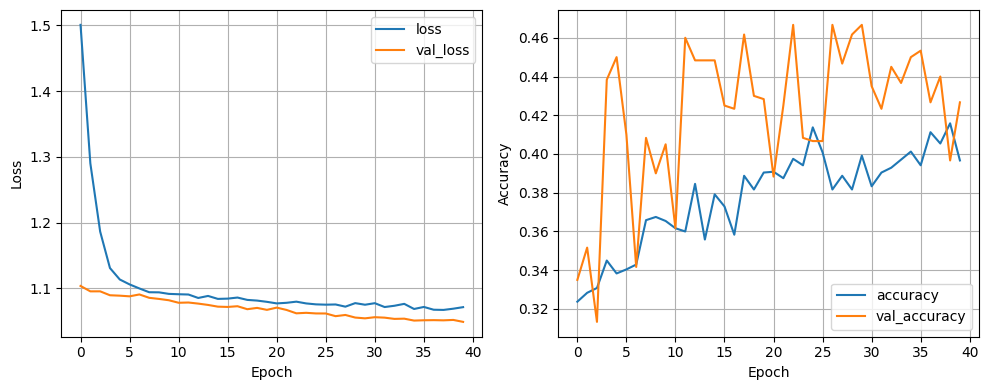

In [11]:
# visualize training and testing result
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Visualize and monitor the training progress and performance of your model. It enables you to observe various metrics, such as training loss and accuracy, validation loss and accuracy, and more, over the course of training.

In [12]:

import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  0
False
